За основу я взяла датасет от Сбербанка:
https://www.kaggle.com/competitions/sberbank-russian-housing-market  
Это набор данных об объектах недвижимости в Москве, по которым были совершены сделки с 2011 по 2016 год.  
Датасет содержит информацию о здании, окружающем районе и цене сделки.

In [314]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

Импортируем датасет:

In [315]:
train = pd.read_csv('sber.csv')
train.head(5)

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9.0,4.0,0.0,13.0,22.0,1.0,0.0,52.0,4.0,5850000.0
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15.0,3.0,0.0,15.0,29.0,1.0,10.0,66.0,14.0,6000000.0
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10.0,3.0,0.0,11.0,27.0,0.0,4.0,67.0,10.0,5700000.0
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11.0,2.0,1.0,4.0,4.0,0.0,0.0,26.0,3.0,13100000.0
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319.0,108.0,17.0,135.0,236.0,2.0,91.0,195.0,14.0,16331452.0


Визуально видно, что в таблице много пропусков. Есть целые столбцы без информации. Удалим все столбцы, в которых есть пропущенные данные (если в столбце есть пропущенные данные, то их в большинстве случаев больше половины).

In [316]:
train = train[train["price_doc"].notnull()] # был только один Nan, а это самый важный столбец
train = train.drop(['ecology', 'timestamp', "product_type"], axis=1)
# в ecology не было Nan, но было текстом написано "no information"
for column in train.columns: # удаляем столбцы с Nan
    if train[column].isnull().sum()>0:
        train.drop(column, inplace=True, axis=1)
    if 'ID' in column:
        train.drop(column, inplace=True, axis=1)
# также удалим столбцы, которые не несут смысловой нагрузки, такие как id, дата сделки (мы не будем ее использовать)
# колонку product_type, тк я не поняла что это, а также все столбцы касаемо ID
# ID_metro, ID_railroad_station_walk, ID_railroad_station_avto и тд.

Для начала посмотрим на данные в целом.

Самая низкая цена за объект недвижимости составляла 190,000 рублей, самая высокая - 111,111,112 рублей
Средняя цена за объект недвижимости составляла 6,332,322 рублей, медианная цена - 5,650,000 рублей


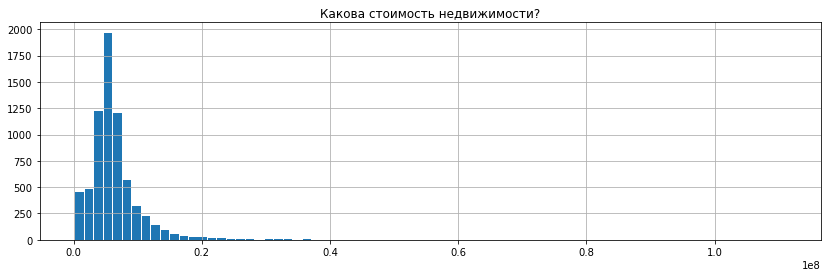

In [317]:
# посмотрим на целевую переменную:
print('Самая низкая цена за объект недвижимости составляла {:,.0f} рублей, самая высокая - {:,.0f} рублей'.format(
    train.price_doc.min(), train.price_doc.max()))
print('Средняя цена за объект недвижимости составляла {:,.0f} рублей, медианная цена - {:,.0f} рублей'.format(
    train.price_doc.mean(), train.price_doc.median()))
train.price_doc.hist(bins=75, rwidth=.9, figsize=(14,4))
plt.title('Какова стоимость недвижимости?')
plt.show()

Самый ближайший объект находится в 0.09 минутах от метро, самый дальний - в 600.32 минутах.


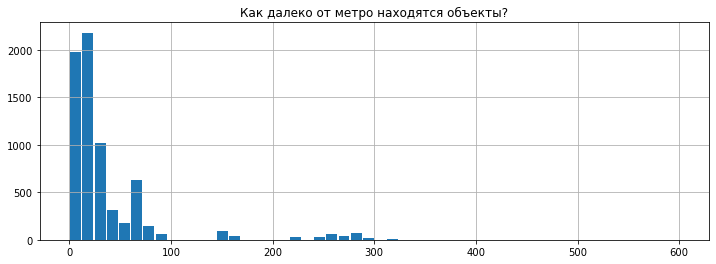

In [318]:
# посмотрим на распределение жилья в зависимости от количества минут пешком до метро
print('Самый ближайший объект находится в {} минутах от метро, самый дальний - в {} минутах.'.format(
    round(train.metro_min_walk.min(),2), round(train.metro_min_walk.max(),2)))
train.metro_min_walk.hist(bins=50, rwidth=.9, figsize=(12,4))
plt.title('Как далеко от метро находятся объекты?')
plt.show()

Большинство жилищ в 0-30 минутах от метро, видимо, это связано с тем, что в Москве много станций.

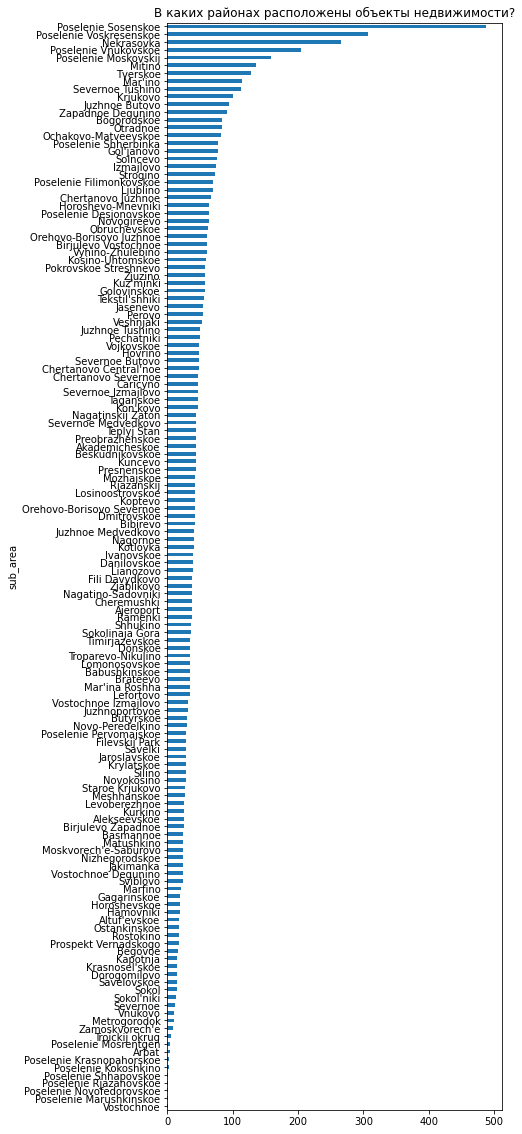

In [319]:
# посмотрим, в каких районах расположены объекты
train.groupby('sub_area').id.count().\
    sort_values().\
    plot(kind='barh', figsize=(6,20))
plt.title('В каких районах расположены объекты недвижимости?')
plt.show()

Самая большая площадь объекта недвижимости составляет 5,326 кв.м., самая маленькая - 5 кв.м.
Средняя площадь объекта недвижимости составляет 54 кв.м., медианная - 45 кв.м.


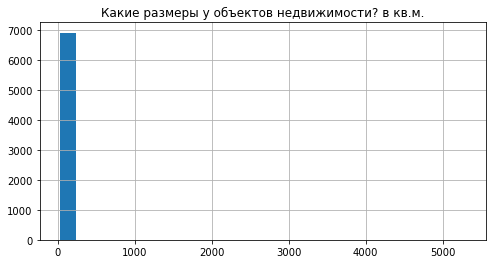

In [320]:
# Насколько большие продаваемые объекты по площади?
print('Самая большая площадь объекта недвижимости составляет {:,.0f} кв.м., самая маленькая - {:,.0f} кв.м.'.format(
    train.full_sq.max(), train.full_sq.min()))
print('Средняя площадь объекта недвижимости составляет {:,.0f} кв.м., медианная - {:,.0f} кв.м.'.format(
    train.full_sq.mean(), train.full_sq.median()))

train.full_sq.hist(bins=21, rwidth=.8, figsize=(8,4))
plt.title('Какие размеры у объектов недвижимости? в кв.м.')
plt.show()

Распределение по стоимости и по площади имеет, судя по гистограммам, очень большие выбросы, мы попробуем выбросить эти значения для улучшения качества предсказаний.

<AxesSubplot:xlabel='full_sq'>

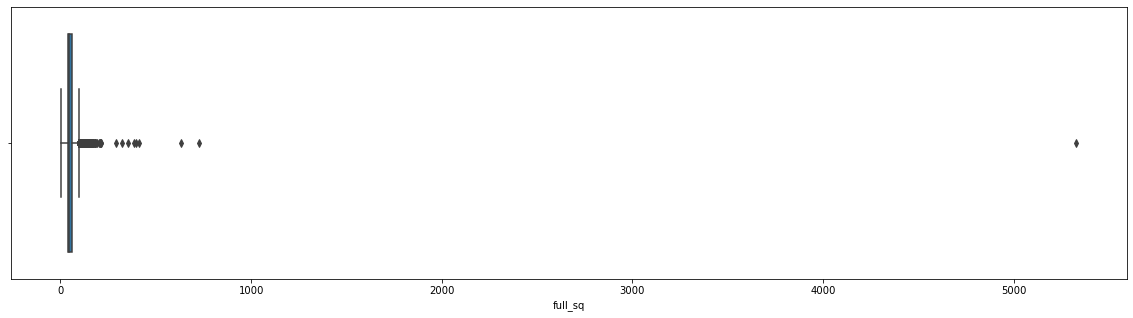

In [321]:
plt.subplots(figsize=(20,5))
sns.boxplot(x=train["full_sq"])

Судя по этому графику мы можем взять объекты площадью менее 250 кв.м.

In [322]:
train.shape

(6906, 237)

In [323]:
train = train[train['full_sq'] < 250]
train.shape

(6897, 237)

Посмотрим на цену.

<AxesSubplot:xlabel='price_doc'>

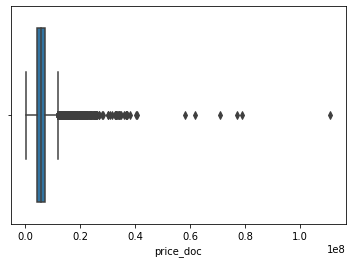

In [324]:
sns.boxplot(x=train["price_doc"])

Исходя из этого графика возьмём объекты стоимостью менее 50 млн.рублей.

In [325]:
train = train[train['price_doc'] < 50000000]
train.shape
# всего на 9 квартир меньше, а данные будут более показательные

(6891, 237)

После корректировки данных, посмотрим на изменившиеся распределения:

Самая большая площадь объекта недвижимости составляет 211 кв.м., самая маленькая - 5 кв.м.
Средняя площадь объекта недвижимости составляет 52 кв.м., медианная - 45 кв.м.


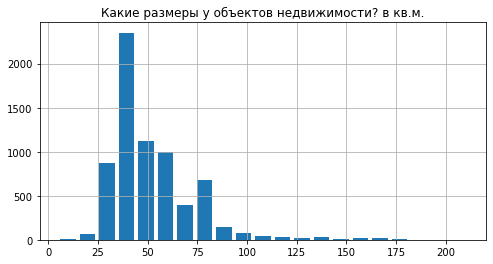

In [326]:
print('Самая большая площадь объекта недвижимости составляет {:,.0f} кв.м., самая маленькая - {:,.0f} кв.м.'.format(
    train.full_sq.max(), train.full_sq.min()))
print('Средняя площадь объекта недвижимости составляет {:,.0f} кв.м., медианная - {:,.0f} кв.м.'.format(
    train.full_sq.mean(), train.full_sq.median()))

train.full_sq.hist(bins=21, rwidth=.8, figsize=(8,4))
plt.title('Какие размеры у объектов недвижимости? в кв.м.')
plt.show()

Самая низкая цена за объект недвижимости составляла 190,000 рублей, самая высокая - 40,500,000 рублей
Средняя цена за объект недвижимости составляла 6,271,083 рублей, медианная цена - 5,650,000 рублей


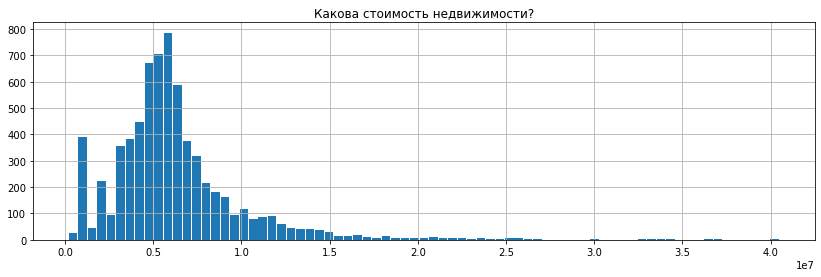

In [327]:
print('Самая низкая цена за объект недвижимости составляла {:,.0f} рублей, самая высокая - {:,.0f} рублей'.format(
    train.price_doc.min(), train.price_doc.max()))
print('Средняя цена за объект недвижимости составляла {:,.0f} рублей, медианная цена - {:,.0f} рублей'.format(
    train.price_doc.mean(), train.price_doc.median()))
train.price_doc.hist(bins=75, rwidth=.9, figsize=(14,4))
plt.title('Какова стоимость недвижимости?')
plt.show()

Выглядит более равномерно.

Ясно, что чтобы оценивать стоимость жилья в зависимости от предоставленных параметров, нам необходимо посчитать стоимость квадратного метра.

In [328]:
train['price_per_sqm'] = train['price_doc']/train['full_sq']
train['price_per_sqm']

0       136046.511628
1       176470.588235
2       132558.139535
3       147191.011236
4       212096.779221
            ...      
6901    154285.714286
6902    154358.454545
6903    144736.842105
6904     84141.509434
6905     81686.278481
Name: price_per_sqm, Length: 6891, dtype: float64

<AxesSubplot:xlabel='price_per_sqm'>

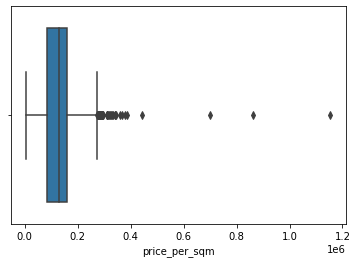

In [329]:
sns.boxplot(x=train["price_per_sqm"])

In [330]:
train = train[train['price_per_sqm'] < 300000]
train.shape

(6870, 238)

Чтобы закончить подготовку датасета к обучению модели, нам надо будет перевести категориальные фичи в числа.

In [331]:
cat_features = list(train.select_dtypes(include=['object']).columns)
cat_features

['sub_area',
 'culture_objects_top_25',
 'thermal_power_plant_raion',
 'incineration_raion',
 'oil_chemistry_raion',
 'radiation_raion',
 'railroad_terminal_raion',
 'big_market_raion',
 'nuclear_reactor_raion',
 'detention_facility_raion',
 'water_1line',
 'big_road1_1line',
 'railroad_1line']

Тк в столбце 'sub_area' содержится много разных значений, мы воспользуемся OneHotEncoder, а другим фичам присвоим значения 1 или 0 в зависимости от того, положительно или отрицательно они предположительно влияют на цену.

In [332]:
OneHotEncoder().fit_transform(np.array(train['sub_area']).reshape(-1, 1))

<6870x140 sparse matrix of type '<class 'numpy.float64'>'
	with 6870 stored elements in Compressed Sparse Row format>

In [333]:
result = train.reset_index(drop=True)
enc = OneHotEncoder()
enc_df = pd.DataFrame(enc.fit_transform(train[['sub_area']]).toarray())
train = pd.concat([result, enc_df], axis=1)
train.drop(["sub_area"], axis=1, inplace=True)
train

,id,full_sq,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,...,130,131,132,133,134,135,136,137,138,139
0,1,43,6.407578e+06,155572,0.189727,0.000070,9576,5,10309,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,34,9.589337e+06,115352,0.372602,0.049637,6880,5,7759,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,43,4.808270e+06,101708,0.112560,0.118537,5879,4,6207,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89,1.258354e+07,178473,0.194703,0.069753,13087,9,13670,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,77,8.398461e+06,108171,0.015234,0.037316,5706,7,6748,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6865,6904,35,9.946335e+06,139322,0.065409,0.225825,6400,7,6558,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6866,6905,88,9.249237e+06,156377,0.374068,0.000000,10190,5,11319,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6867,6906,76,7.750778e+06,76284,0.094681,0.313925,4935,4,4625,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6868,6907,106,1.258354e+07,178473,0.194703,0.069753,13087,9,13670,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [334]:
train['culture_objects_top_25'] = train['culture_objects_top_25'].map({'no': 0, 'yes': 1})
train['thermal_power_plant_raion'] = train['thermal_power_plant_raion'].map({'no': 0, 'yes': 1})
train['incineration_raion'] = train['incineration_raion'].map({'no': 1, 'yes': 0})
train['oil_chemistry_raion'] = train['oil_chemistry_raion'].map({'no': 1, 'yes': 0})
train['radiation_raion'] = train['radiation_raion'].map({'no': 1, 'yes': 0})
train['railroad_terminal_raion'] = train['railroad_terminal_raion'].map({'no': 0, 'yes': 1})
train['big_market_raion'] = train['big_market_raion'].map({'no': 0, 'yes': 1})
train['nuclear_reactor_raion'] = train['nuclear_reactor_raion'].map({'no': 1, 'yes': 0})
train['detention_facility_raion'] = train['detention_facility_raion'].map({'no': 1, 'yes': 0})
train['water_1line'] = train['water_1line'].map({'no': 0, 'yes': 1})
train['big_road1_1line'] = train['big_road1_1line'].map({'no': 1, 'yes': 0})
train['railroad_1line'] = train['railroad_1line'].map({'no': 1, 'yes': 0})

Подготовим данные для модели на выбранных параметрах.

In [335]:
X = train.copy()
X.drop(['id', 'price_per_sqm', "price_doc"], axis=1, inplace=True)

In [336]:
y = train['price_per_sqm']

In [337]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, train_size=0.8)

In [338]:
reg = LinearRegression() # создаем класс
reg.fit(X_train, y_train)

LinearRegression()

In [339]:
y_pred = reg.predict(X_valid)
y_pred_train = reg.predict(X_train)

In [340]:
print("Средняя ошибка на обучении: %.3f" % sqrt(mean_squared_error(y_train, y_pred_train)))
print("Средняя ошибка на валидации: %.3f" % sqrt(mean_squared_error(y_valid, y_pred)))

Средняя ошибка на обучении: 40646.024
Средняя ошибка на валидации: 45711.382


Мне показалось, что метрика корня из MSE хороша тем, что по сути это сопоставимые данные в рублях. Для цены за квадратный метр ошибка достаточно большая.

In [341]:
from sklearn.metrics import r2_score

print("R2 на обучении: %.3f" % r2_score(y_train, y_pred_train))
print("R2 на валидации: %.3f" % r2_score(y_valid, y_pred))

R2 на обучении: 0.381
R2 на валидации: 0.213


Как мы видим, пока что не очень хорошие показатели.

Попробуем обучить другую модель.

In [344]:
# rfr = RandomForestRegressor(random_state = 1)
rfr = RandomForestRegressor()

In [345]:
rfr.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [346]:
param_grid = {'bootstrap': [True], 'max_depth': [5, 10, None], \
              'max_features': ['auto', 'log2'], 'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15]}

g_search = GridSearchCV(estimator = rfr, param_grid = param_grid, \
                        cv = 3, n_jobs = 1, verbose = 0, return_train_score=True)

In [347]:
g_search.fit(X_train, y_train)
print(g_search.best_params_)

{'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 12}


In [348]:
rfr_upd = RandomForestRegressor(bootstrap=True, max_depth = 5, max_features = 'auto', n_estimators = 15)

In [349]:
rfr_upd.fit(X_train, y_train)
y_pred_rfr = rfr_upd.predict(X_valid)
y_pred_rfr_train = rfr_upd.predict(X_train)

In [350]:
print("Средняя ошибка на обучении: %.3f" % sqrt(mean_squared_error(y_train, y_pred_rfr_train)))
print("Средняя ошибка на валидации: %.3f" % sqrt(mean_squared_error(y_valid, y_pred_rfr)))

Средняя ошибка на обучении: 41262.076
Средняя ошибка на валидации: 44805.479


Расчет ошибки с помощью кросс-валидации:

In [351]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rfr_upd, X, y, cv=10, scoring='neg_mean_squared_error')
scores

array([-2.82652437e+09, -2.76447381e+09, -2.71846330e+09, -2.57227808e+09,
       -2.20081474e+09, -1.33104542e+09, -8.95921286e+08, -8.93709531e+08,
       -1.59908839e+09, -1.13089549e+09])

In [352]:
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
sqrt(-scores.mean())

43512.3136770894

Я ещё попробовала логарифмировать целевой вектор и обучить линейную регрессию на нём.

In [353]:
y_train_log = np.log(y_train)
y_valid_log = np.log(y_valid)

In [354]:
reg_2 = LinearRegression()
reg.fit(X_train, y_train_log)
y_pred_log = reg.predict(X_valid)
y_pred_train_log = reg.predict(X_train)

In [355]:
y_pred_antilog = np.exp(y_pred_log)
y_pred_train_antilog = np.exp(y_pred_train_log)
y_train_antilog = np.exp(y_train_log)
y_valid_antilog = np.exp(y_valid_log)

In [356]:
print("Средняя ошибка на обучении: %.3f" % sqrt(mean_squared_error(y_train_antilog, y_pred_train_antilog)))
print("Средняя ошибка на валидации: %.3f" % sqrt(mean_squared_error(y_valid_antilog, y_pred_antilog)))

Средняя ошибка на обучении: 43560.947
Средняя ошибка на валидации: 48278.509


Результаты так себе. Скорее всего, это связано с тем, что данные, собранные для датасета, не очень сильно коррелируют с целевой переменной и не оказывают решающего влияния на цену за кв.метр.